# PLANET DATASET: UNDERSTANDING THE AMAZON FROM SPACE

### Import necessary libraries and load the data

In [1]:
# Importing the necessary libraries
import os
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import gc 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from matplotlib.image import imread
from sklearn.model_selection import train_test_split
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping 
from keras.preprocessing.image import ImageDataGenerator

%matplotlib inline
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [2]:
# List of directories
path = "../input/planets-dataset/"
os.listdir(path)

['planet', 'test-jpg-additional']

## Loading the Data

In [3]:
#Loading the image datasets
train_path = '../input/planets-dataset/planet/planet/train_classes.csv'
test_path = '../input/planets-dataset/planet/planet/sample_submission.csv'
train_images = '../input/planets-dataset/planet/planet/train-jpg/'
test_images = '../input/planets-dataset/planet/planet/test-jpg/'

# Loading the train and test datasets
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Sanity checking
assert str(type(train_df)) == "<class 'pandas.core.frame.DataFrame'>"
assert str(type(test_df)) == "<class 'pandas.core.frame.DataFrame'>"

print('Shape of Train Set:', train_df.shape)
print('Shape of Test Set:', test_df.shape)
train_df.head()

Shape of Train Set: (40479, 2)
Shape of Test Set: (61191, 2)


,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [4]:
test_df.head()

,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


## Exploratory Data Analysis

Let's view some image samples

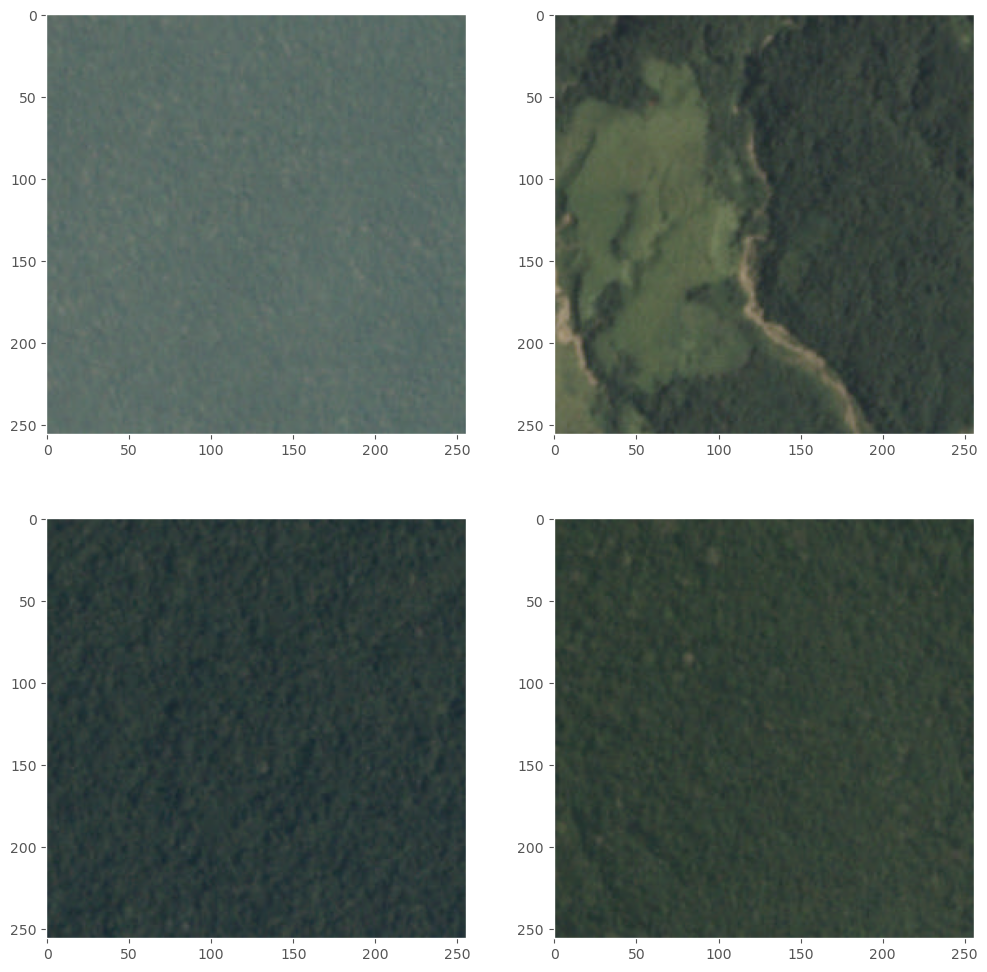

In [5]:
# Let's view some images
plt.figure(figsize=(12,12))
# define location of dataset
folder = train_images
no_images = 4
for i in range(no_images):
    n_rows = 2
    n_cols = int(no_images/n_rows)
    subplot_index = i + 1
    plt.subplot(n_rows,n_cols, subplot_index)
    filename = folder + 'train_' + str(i) + '.jpg'
    image = imread(filename)
    plt.grid(False)
    plt.imshow(image)
plt.show()

### How many images in Train and Test sets

In [6]:
print('Number of Images in Train set:', train_df.shape[0])
print('Number of Images in Test set:', test_df.shape[0])
print('Number of Unique samples in Train set:', train_df['tags'].nunique())

Number of Images in Train set: 40479
Number of Images in Test set: 61191
Number of Unique samples in Train set: 449


### What is the frequency of occurence of each tag?

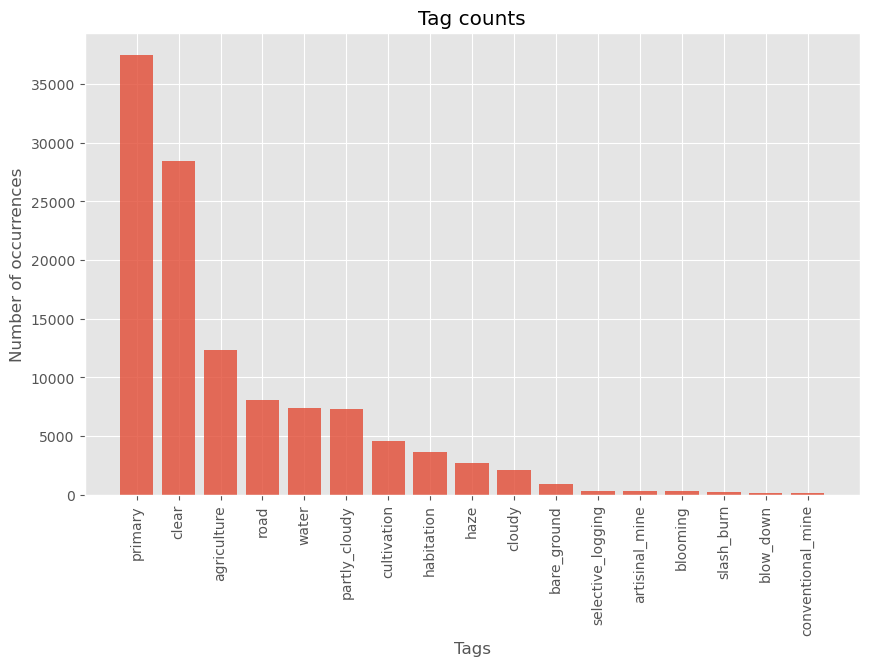

In [7]:
# Tags present in the dataset
tags = train_df['tags'].apply(lambda x: x.split(' '))
tags = [item for sublist in tags for item in sublist]
tag_counts = pd.Series(tags).value_counts()

# Plot the tags
plt.figure(figsize=(10,6))
plt.bar(tag_counts.index, tag_counts.values, alpha=0.8)
plt.title('Tag counts')
plt.ylabel('Number of occurrences', fontsize=12)
plt.xlabel('Tags', fontsize=12)
plt.xticks(rotation=90)
plt.show();

### Preprocessing the data

In [8]:
working = train_df.copy()

# Create an empty set to store the unique labels

labels = set()

# Function to split and add tags to the 'labels' set
def splitting_tags(tags):
    labels.update(tags.split())

# Apply the 'splitting_tags' function to each element in the 'tags' column
working['tags'].apply(splitting_tags)

# Convert the set of unique labels to a list
labels_list = list(labels)

# Print the list of unique labels
print(labels_list)


['selective_logging', 'road', 'clear', 'bare_ground', 'blooming', 'partly_cloudy', 'cultivation', 'artisinal_mine', 'water', 'haze', 'blow_down', 'conventional_mine', 'cloudy', 'primary', 'slash_burn', 'agriculture', 'habitation']


In [9]:
from sklearn.preprocessing import MultiLabelBinarizer

# Create a MultiLabelBinarizer object
mlb = MultiLabelBinarizer()

# One-hot encode the 'tags' column and replace the original 'tags' column with the encoded labels
one_hot_labels = mlb.fit_transform(working['tags'].str.split())
working[mlb.classes_] = one_hot_labels  # Add the one-hot encoded labels as new columns

# Add ".jpg" extension to each image name in the 'image_name' column
working['image_name'] = working['image_name'].apply(lambda x: f'{x}.jpg')

# Display the updated DataFrame
working.head()

,image_name,tags,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,train_0.jpg,haze primary,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1,train_1.jpg,agriculture clear primary water,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
2,train_2.jpg,clear primary,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,train_3.jpg,clear primary,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,train_4.jpg,agriculture clear habitation primary road,1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0


In [10]:
# Define the columns
columns = list(working.columns[2:])
columns

['agriculture',
 'artisinal_mine',
 'bare_ground',
 'blooming',
 'blow_down',
 'clear',
 'cloudy',
 'conventional_mine',
 'cultivation',
 'habitation',
 'haze',
 'partly_cloudy',
 'primary',
 'road',
 'selective_logging',
 'slash_burn',
 'water']

In [11]:
gc.collect()

16338

In [12]:
# Initializing imagedatagenerator with a validation split of 0.2
train_datagen = ImageDataGenerator(rescale = 1./255., validation_split = 0.2)

# Generating train data generator 
train_generator = train_datagen.flow_from_dataframe(dataframe=working,
                                                    directory =train_images, 
                                                    x_col='image_name', y_col=columns, subset='training', 
                                                    batch_size=32,seed=42, shuffle=True, 
                                                    class_mode='raw', target_size=(128,128))

#generating validation data which is expected to be 20% of the train dataset since validation split is 0.2
val_generator = train_datagen.flow_from_dataframe(dataframe=working,
                                                  directory =train_images, 
                                                  x_col='image_name', y_col=columns, subset='validation', 
                                                  batch_size=32,seed=42, shuffle=True, 
                                                  class_mode='raw', target_size=(128,128))

Found 32384 validated image filenames.
Found 8095 validated image filenames.


In [13]:
#setting up step size for training and validation image data
step_train_size = int(np.ceil(train_generator.samples / train_generator.batch_size))
step_val_size = int(np.ceil(val_generator.samples / val_generator.batch_size))

In [14]:
gc.collect()

42

### Modelling

In [15]:
# Define the model
def cnn_model():
    model = Sequential()

    # Convolution layers
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(128, 128, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten layer
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(units=512, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=17, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer=Adam(lr=0.001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    return model

In [16]:
#initialize the model
model = cnn_model()

# Preview the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 128)      0

In [17]:
# define callbacks
earlystop = EarlyStopping(monitor='val_accuracy', 
                          patience=2, verbose=1, 
                          mode='max', 
                          restore_best_weights=True)

In [18]:
gc.collect()

178

In [19]:
# Fit the model 
history = model.fit(x = train_generator, 
                    steps_per_epoch = step_train_size, 
                    validation_data = val_generator,
                    validation_steps = step_val_size,
                    epochs = 20, 
                    callbacks = [earlystop])

Epoch 1/20
1012/1012 [==============================] - 356s 337ms/step - loss: 0.2024 - accuracy: 0.0321 - val_loss: 0.1712 - val_accuracy: 0.0269
Epoch 2/20
1012/1012 [==============================] - 146s 145ms/step - loss: 0.1554 - accuracy: 0.0999 - val_loss: 0.1387 - val_accuracy: 0.0862
Epoch 3/20
1012/1012 [==============================] - 145s 143ms/step - loss: 0.1421 - accuracy: 0.1324 - val_loss: 0.1333 - val_accuracy: 0.0728
Epoch 4/20
1012/1012 [==============================] - 146s 144ms/step - loss: 0.1347 - accuracy: 0.1435 - val_loss: 0.1271 - val_accuracy: 0.0746
Epoch 4: early stopping


In [20]:
gc.collect()

42

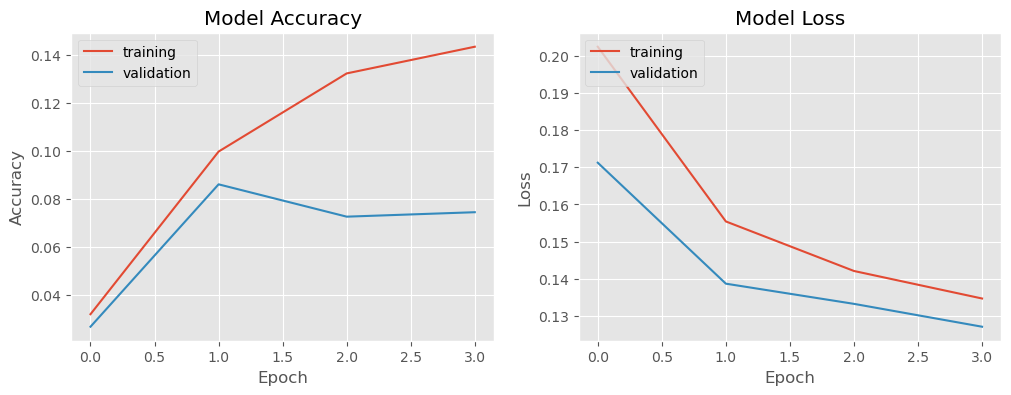

In [21]:
# Plot the training and validation accuracy and loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')

plt.show()

In [22]:
gc.collect()

7017

In [23]:
#initializing a second model to make predictions
model1 = cnn_model()

In [24]:
##adding .jpg extension to image name in the sample submission file
sample_submission = pd.read_csv('../input/planets-dataset/planet/planet/sample_submission.csv')
sample_submission1 = sample_submission.copy()
sample_submission1['image_name'] = sample_submission1['image_name'].apply(lambda x: '{}.jpg'.format(x))
sample_submission1.head()

,image_name,tags
0,test_0.jpg,primary clear agriculture road water
1,test_1.jpg,primary clear agriculture road water
2,test_2.jpg,primary clear agriculture road water
3,test_3.jpg,primary clear agriculture road water
4,test_4.jpg,primary clear agriculture road water


In [25]:
# Divide the sample submission file into two splits,
# first test1_df contains the first 40669 images 
test_df1 = sample_submission1.iloc[:40669]['image_name'].reset_index().drop('index', axis =1)
test_df1.head()

,image_name
0,test_0.jpg
1,test_1.jpg
2,test_2.jpg
3,test_3.jpg
4,test_4.jpg


In [26]:
#initialize imagedatagenerator for the test images and also rescaling
test_datagen = ImageDataGenerator(rescale = 1/255)

#creating a generator for the images found in the first test image files
test_gen = test_datagen.flow_from_dataframe(dataframe=test_df1, 
                                            directory='/kaggle/input/planets-dataset/planet/planet/test-jpg/', 
                                            x_col="image_name", 
                                            y_col=None, 
                                            batch_size=32,
                                            seed=42,
                                            shuffle=False, 
                                            class_mode=None, 
                                            target_size=(128,128))

step_test_size1 = int(np.ceil(test_gen.samples/test_gen.batch_size))

Found 40669 validated image filenames.


In [27]:
#first, we reset the test generator to avoid shuffling of index 
test_gen.reset()
pred = model1.predict(test_gen, steps=step_test_size1, verbose=1)

1271/1271 [==============================] - 300s 236ms/step


In [28]:
# Convert the predicted values to a DataFrame and join labels together if prob(occurrence of the label) > 0.5
pred_tags = pd.DataFrame(pred, columns=labels_list)
pred_tags = pred_tags.apply(lambda row: ' '.join(pred_tags.columns[row > 0.5]), axis=1)

# Get the filenames in the generator using the attribute .filenames
file_names = test_gen.filenames

# Create the result DataFrame
result1 = pd.DataFrame({'image_name': file_names, 'tags': pred_tags})

# Add ".jpg" extension to each image name in the 'image_name' column
result1['image_name'] = result1['image_name'].apply(lambda x: f'{x}')

result1.head()

,image_name,tags
0,test_0.jpg,road clear partly_cloudy cultivation artisinal...
1,test_1.jpg,road clear partly_cloudy cultivation artisinal...
2,test_2.jpg,road clear partly_cloudy artisinal_mine water ...
3,test_3.jpg,road clear partly_cloudy artisinal_mine water ...
4,test_4.jpg,road clear partly_cloudy cultivation artisinal...


In [29]:
gc.collect()

42

In [30]:
#second batch of the test dataset
additional_df = sample_submission1.iloc[40669:]['image_name'].reset_index().drop('index', axis =1)
additional_df.head()

,image_name
0,file_0.jpg
1,file_1.jpg
2,file_10.jpg
3,file_100.jpg
4,file_1000.jpg


In [31]:
#creating a generator for the second batch of test image files
test_gen1 = test_datagen.flow_from_dataframe(dataframe=additional_df, 
                                                directory='../input/planets-dataset/test-jpg-additional/test-jpg-additional', 
                                                x_col='image_name', 
                                                y_col=None, 
                                                batch_size=32, 
                                                shuffle=False, 
                                                class_mode=None, 
                                                target_size=(128,128))

step_test_size2 = int(np.ceil(test_gen1.samples/test_gen1.batch_size))

Found 20522 validated image filenames.


In [32]:
#we reset the generator to avoid shuffling, then make prediction on the generator
test_gen1.reset()
pred1 = model1.predict(test_gen1, steps = step_test_size2, verbose = 1)

642/642 [==============================] - 151s 235ms/step


In [33]:
#this is to get the filenames in the generator using the attribute .filenames
file_names1 = test_gen1.filenames

#convert the predicted values to a dataframe
#join two labels together if the prob(occurrance of the label) > 0.5
pred_tags1 = pd.DataFrame(pred1)
pred_tags1 = pred_tags1.apply(lambda x: ''.join(np.array(labels_list)[x>0.5]), axis = 1)

result2 = pd.DataFrame({'image_name': file_names1, 'tags': pred_tags1})
result2.head()

,image_name,tags
0,file_0.jpg,roadclearpartly_cloudyartisinal_minewaterblow_...
1,file_1.jpg,roadclearpartly_cloudycultivationwaterblow_dow...
2,file_10.jpg,roadclearpartly_cloudycultivationartisinal_min...
3,file_100.jpg,roadclearpartly_cloudycultivationartisinal_min...
4,file_1000.jpg,roadclearpartly_cloudycultivationartisinal_min...


In [34]:
# Final result of the predicted tags for the test images,
# we need to concat the first and second results in 
#that order to avoid shuffling the index
final_df = pd.concat([result1, result2])

final_df = final_df.reset_index().drop('index', axis =1)

print(final_df.shape)
final_df.head()

(61191, 2)


,image_name,tags
0,test_0.jpg,road clear partly_cloudy cultivation artisinal...
1,test_1.jpg,road clear partly_cloudy cultivation artisinal...
2,test_2.jpg,road clear partly_cloudy artisinal_mine water ...
3,test_3.jpg,road clear partly_cloudy artisinal_mine water ...
4,test_4.jpg,road clear partly_cloudy cultivation artisinal...


In [35]:
# Remove the .jpg extension from the image_name of the last_result 
final_df['image_name'] = final_df['image_name'].apply(lambda x: x[:-4])
final_df.head()

,image_name,tags
0,test_0,road clear partly_cloudy cultivation artisinal...
1,test_1,road clear partly_cloudy cultivation artisinal...
2,test_2,road clear partly_cloudy artisinal_mine water ...
3,test_3,road clear partly_cloudy artisinal_mine water ...
4,test_4,road clear partly_cloudy cultivation artisinal...


In [36]:
# Finally, we save the result to a csv file using the .to_csv() 
# method and setting the index to false.
final_df.to_csv('submission.csv', index = False)